In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /Users/uni/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/uni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/uni/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/uni/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/uni/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [3]:
df = pd.read_csv("comments.csv")
df = df[["text", "toxic"]].dropna()
df["text"] = df["text"].astype(str)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text", "toxic"]].head()

,text,clean_text,toxic
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...,0
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m se...,0
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...,0
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on impr...,0
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...,0


In [7]:
lemmatizer = WordNetLemmatizer()

def to_wordnet_pos(tag: str):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

In [9]:
def lemmatize_text(s: str) -> str:
    tokens = s.split()
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(w, to_wordnet_pos(t)) for w, t in tagged]
    return " ".join(lemmas)

df["lemm_text"] = df["clean_text"].apply(lemmatize_text)
df[["clean_text", "lemm_text"]].head()

,clean_text,lemm_text
0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [11]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(s: str) -> str:
    tokens = s.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["final_text"] = df["lemm_text"].apply(remove_stopwords)
df[["lemm_text", "final_text"]].head()

,lemm_text,final_text
0,explanation why the edits make under my userna...,explanation edits make username hardcore metal...
1,d aww he match this background colour i m seem...,aww match background colour seemingly stick th...
2,hey man i m really not try to edit war it s ju...,hey man really try edit war guy constantly rem...
3,more i can t make any real suggestion on impro...,make real suggestion improvement wonder sectio...
4,you sir be my hero any chance you remember wha...,sir hero chance remember page


In [13]:
vectorizer = TfidfVectorizer(min_df=2)
tfidf = vectorizer.fit_transform(df["final_text"])
terms = vectorizer.get_feature_names_out()
tfidf.shape

(159571, 62082)

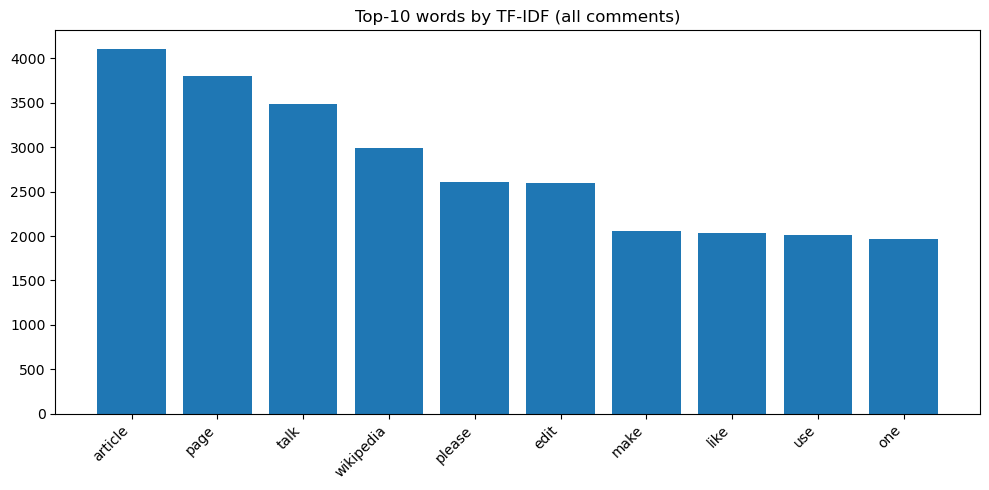

[('article', 4109.187538995387),
 ('page', 3798.1218900037247),
 ('talk', 3483.8977095257683),
 ('wikipedia', 2990.8044757375856),
 ('please', 2612.9891656373948),
 ('edit', 2597.4054419366885),
 ('make', 2059.3521460791535),
 ('like', 2031.2061861721418),
 ('use', 2008.3550901329884),
 ('one', 1963.987225559189)]

In [15]:
tfidf_sum = np.asarray(tfidf.sum(axis=0)).ravel()
top_idx = tfidf_sum.argsort()[::-1][:10]
top_words = terms[top_idx]
top_scores = tfidf_sum[top_idx]

plt.figure(figsize=(10,5))
plt.bar(top_words, top_scores)
plt.xticks(rotation=45, ha="right")
plt.title("Top-10 words by TF-IDF (all comments)")
plt.tight_layout()
plt.show()

list(zip(top_words, top_scores))

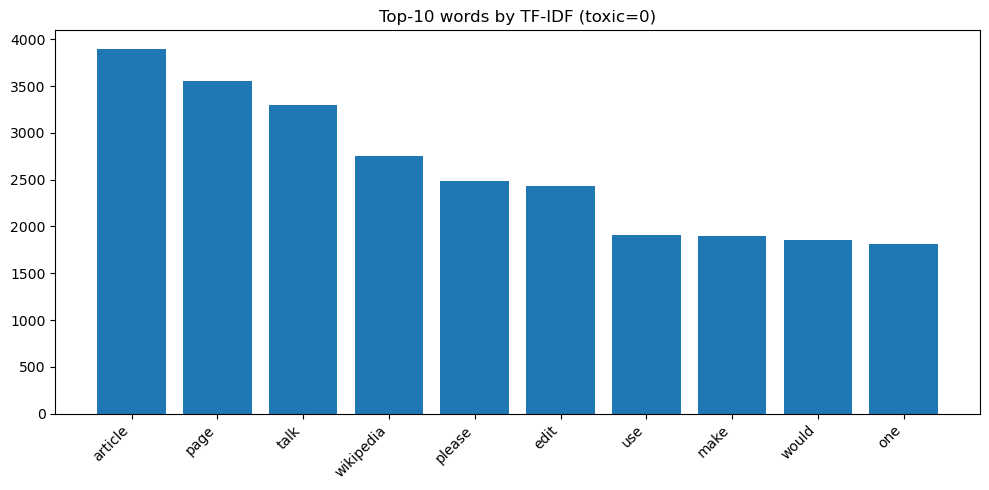

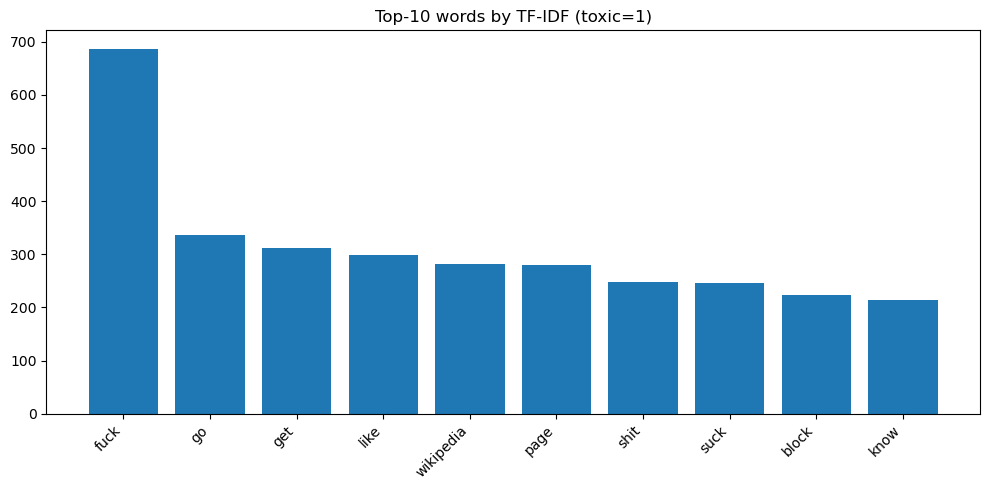

([('article', 3900.3286846569927),
  ('page', 3552.0660696944337),
  ('talk', 3292.953735053296),
  ('wikipedia', 2753.2505076272155),
  ('please', 2483.4924470465735),
  ('edit', 2436.8966433351106),
  ('use', 1910.7858149788256),
  ('make', 1893.6243423944932),
  ('would', 1850.5768617119709),
  ('one', 1817.1733479549448)],
 [('fuck', 687.1483200408738),
  ('go', 337.10962157261906),
  ('get', 312.29005851901854),
  ('like', 298.0771193716703),
  ('wikipedia', 281.14359002673126),
  ('page', 279.5018133556403),
  ('shit', 247.01660202780064),
  ('suck', 245.15031502175907),
  ('block', 223.84525059333194),
  ('know', 214.83014808037183)])

In [17]:
def top10_tfidf_for_subset(sub_df: pd.DataFrame, title: str):
    v = TfidfVectorizer(min_df=2)
    X = v.fit_transform(sub_df["final_text"])
    t = v.get_feature_names_out()
    s = np.asarray(X.sum(axis=0)).ravel()
    idx = s.argsort()[::-1][:10]
    w = t[idx]
    sc = s[idx]

    plt.figure(figsize=(10,5))
    plt.bar(w, sc)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return list(zip(w, sc))

top_pos = top10_tfidf_for_subset(df[df["toxic"] == 0], "Top-10 words by TF-IDF (toxic=0)")
top_neg = top10_tfidf_for_subset(df[df["toxic"] == 1], "Top-10 words by TF-IDF (toxic=1)")

top_pos, top_neg